In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
orders = pd.read_csv("ab_orders.csv")
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [4]:
products = pd.read_csv("ab_products.csv")
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [5]:
users_data = pd.read_csv("ab_users_data.csv")
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


В качестве оснвоной метрики будем считать общую сумму купленных товаров.
В качестве дополнительной метрики возьмем среднее число товаров, купленное пользователем (число купленных товаров, деленное на число ордеров пользователя). Разумно ожидать, что система рекомендаций должна увеличить пользовательскую корзину и за счет этого увеличить прибыль.

In [6]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [7]:
for i in orders.product_ids[0]:
    print(i)

{
7
5
,
 
2
2
,
 
5
3
,
 
8
4
}


In [15]:
def make_prices(str):
    ids = list(map(int, str[1:-1].split(', ')))
    final_price = 0
    for i in ids:
        final_price += products.price[i-1]
    return final_price


200.0

In [16]:
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [19]:
df = users_data.merge(orders, on='order_id')

In [20]:
df['avenue'] = df.product_ids.apply(lambda x: make_prices(x))
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,avenue
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",85.0
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",85.0


In [21]:
def cnt_of_items(str):
    ids = list(map(int, str[1:-1].split(', ')))
    return len(ids)

In [22]:
df['cnt_of_items'] = df.product_ids.apply(lambda x: cnt_of_items(x))
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,avenue,cnt_of_items
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",408.7,4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",250.5,3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",310.2,4
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",85.0,2
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",85.0,2


In [25]:
gf = df.groupby('user_id', as_index=False).agg({'group':'max', 'avenue':'sum', 'cnt_of_items':'sum', 'time':'count'}).rename(columns={'time':'cnt_of_orders'})
gf.head()

,user_id,group,avenue,cnt_of_items,cnt_of_orders
0,964,0,718.9,8,2
1,965,1,4155.5,33,9
2,966,0,170.0,4,2
3,967,1,1137.4,18,5
4,968,0,1590.7,11,3


In [27]:
gf['avg_items'] = gf['cnt_of_items'] / gf['cnt_of_orders']

In [28]:
gf_control = gf.query('group == 0')
gf_test = gf.query('group == 1')

In [29]:
from scipy import stats
print(stats.shapiro(gf_control.avg_items))
print(stats.shapiro(gf_test.avg_items))

ShapiroResult(statistic=0.9710928797721863, pvalue=1.519354242418558e-08)
ShapiroResult(statistic=0.9710738062858582, pvalue=2.1384790827028155e-08)


На любом разумном уровне значимости гипотеза о нормальном распределении средних отклоняется

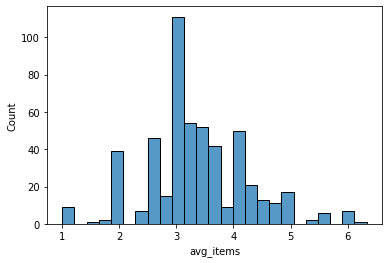

In [30]:
sns.histplot(gf_control.avg_items)

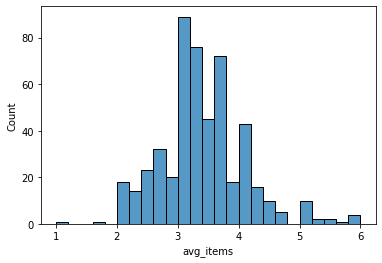

In [31]:
sns.histplot(gf_test.avg_items)

Никакому логарифму это не исправить

In [32]:
from scipy.stats import mannwhitneyu
stats.mannwhitneyu(gf_control.avg_items, gf_test.avg_items)

MannwhitneyuResult(statistic=125046.0, pvalue=0.36628610848961485)

На уровне 5\% мы не отклоняем гипотезу о равенстве распределений, в пользу гипотезе о неравенстве

Не теряем надежду, может увеличилась основная метрика

In [33]:
print(stats.shapiro(gf_control.avenue))
print(stats.shapiro(gf_test.avenue))

ShapiroResult(statistic=0.8934255838394165, pvalue=1.9825922824313846e-18)
ShapiroResult(statistic=0.9725738167762756, pvalue=4.3736186228215956e-08)


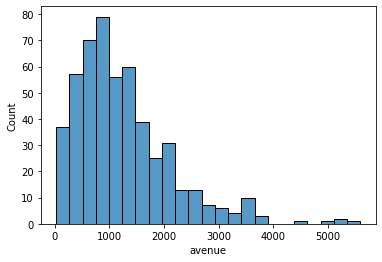

In [34]:
sns.histplot(gf_control.avenue)

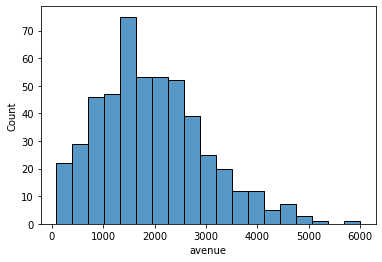

In [35]:
sns.histplot(gf_test.avenue)

Похоже, что логарифм подправит распределение в сторону нормального. Однако несильно, ради этого не хочется и неправильно подменять основную метрику

In [36]:
stats.mannwhitneyu(gf_control.avenue, gf_test.avenue)

MannwhitneyuResult(statistic=73769.5, pvalue=2.1541646001608705e-32)

На любом разумном уровне значимости мы отклоняем гипотезу о равенстве распределений

Посмотрим на среднее и медиану

In [37]:
print(gf_control.avenue.mean())
print(gf_test.avenue.mean())

1249.5566990291263
1951.8637450199205


In [38]:
print(gf_control.avenue.median())
print(gf_test.avenue.median())

1044.0
1791.9499999999998


Как мы видим, и среднее и медиана стали больше

Вывод: Основная метрика увеличилась при новой системе (мы рассматривали ее на уровне значимости 5\%).
Однако, метрика, от которой мы ождали значимые изменения их не показала. 
Новая система рекомендуется к реализации, однако необходимо пересмотреть теоретическое обоснование её влияния.